# How Convolution layer works?


- 기수:  14기

- 이름:  권나연

- 작성자: 13기 강승우

압축을 해제한 폴더 그대로 경로 변경 없이 문제를 푸시면됩니다.  
**CNN assignment폴더 아래에 data폴더, CNN 노트북파일, 이미지파일이 위치해야합니다.**  
문제가 생길 경우 경로 코드를 수정하시거나, 학술부에게 문의해주세요

이번 문제에서는 직접 Convolution 연산을 구현해보며 CNN의 동작 원리를 알아보고자 합니다.

**목표**
- `nn.Conv2d`와 동일한 연산을 **NumPy로 직접 구현**
- laplacian filter와 sobel filter를 **이미지에 적용**

**라이브러리 및 함수 정의**

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, Optional

# 시각화 유틸
def show_gray(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def minmax_norm(x: np.ndarray, eps: float = 1e-12):
    mn, mx = np.min(x), np.max(x)
    if mx - mn < eps:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

**이미지 준비**

Mounted at /content/drive


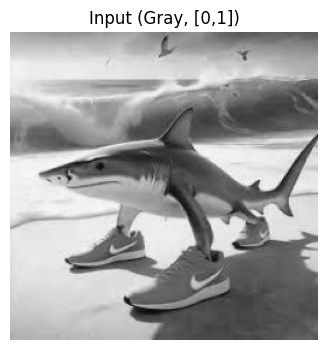

In [15]:
from google.colab import drive
drive.mount('/content/drive')

def load_image(path: Optional[str] = None, size: Tuple[int,int]=(256,256)) -> np.ndarray:
    img = Image.open(path).convert('L').resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

# 사용 예시: path=None -> 합성 이미지
img = load_image(path="/content/drive/My Drive/Colab Notebooks/data/tralla.jpg", size=(256,256))
show_gray(img, title='Input (Gray, [0,1])')

**Q1. numpy를 사용하여 이미지와 커널 배열을 입력으로 받는 conv2D_naive 함수를 구현하세요**

In [16]:
def conv2d_naive(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    image: (H, W)
    kernel: (kH, kW)

    반환: (outH, outW)
    """
    # padding=0, stride=1 조건으로 구현
    padding = 0
    padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
    stride = 1

    ## Todo ##
    h, w = image.shape
    kH, kW = kernel.shape
    outH = (h + 2 * padding - kH) // stride + 1
    outW = (w + 2 * padding - kW) // stride + 1

    out = np.zeros((outH, outW), dtype=image.dtype)

    for i in range(outH):
        for j in range(outW):
            # Extract the region of interest from the padded image
            roi = padded[i * stride : i * stride + kH, j * stride : j * stride + kW]
            # Perform element-wise multiplication and sum
            out[i, j] = np.sum(roi * kernel)

    ##########
    return out

**Q2. 작성한 코드의 동작 방식이 왜 CNN의 convolution 연산과 동일한지 아래 마크다운에 자세히 설명해주세요. (예시를 들어 설명하셔도 좋습니다)**

H, W = 이미지의 크기(높이, 너비)

kH, kW = 필터의 크기(높이, 너비)

outH: 세로로  필터가 몇 번 움직일 수 있는지 = 출력 이미지의 높이

outW: 가로로 필터가 몇 번 움직일 수 있는지 = 출력 이미지의 너비

(*1은 시작 고려하여 더해주는 값)

가로로 움직이면서 필터가 덮는 부분을 region으로 잡고 원소곱 → 출력 이미지에서 (i, j) 위치 값

**라플라시안 필터 적용 및 시각화**


- Laplace Filter  
\begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}

- Sobel Filter(수직)  
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}

- Sobel Filter(수평)
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}


In [17]:
laplace = np.array([[ 1, 1, 1],
                    [ 1,-8, 1],
                    [ 1, 1, 1]], dtype=np.float32)

sobel_vertical = np.array([[ -1, 0, 1],
                           [ -2, 0, 2],
                           [ -1, 0, 1]], dtype=np.float32)

sobel_horizontal = np.array([[ -1, -2, -1],
                             [  0,  0,  0],
                             [  1,  2,  2]], dtype=np.float32)

print('laplace:\n', laplace)
print('sobel_vertical\n', sobel_vertical)
print('sobel_horizontal:\n', sobel_horizontal)

laplace:
 [[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]
sobel_vertical
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
sobel_horizontal:
 [[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  2.]]


**구현한 Conv함수와 주어진 filter로 이미지의 edge를 검출해보세요**
- 결과의 범위가 음수가 될 수 있어, 시각화를 위해 정규화 사용

In [18]:
def apply_filter_and_visualize(img: np.ndarray, kernel: np.ndarray, stride: int = 1):

    resp = conv2d_naive(img, kernel)
    resp_signed = minmax_norm(resp)      # [-?, +?] -> [0,1] 정규화

    show_gray(img, 'Input')
    show_gray(resp_signed, 'Laplacian response (signed → min-max normalized)')
    return resp

=== Laplacian ===


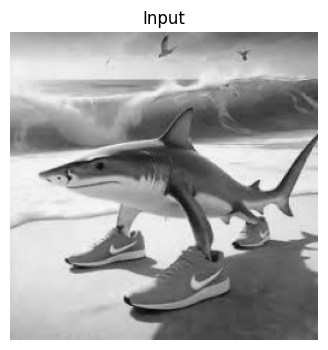

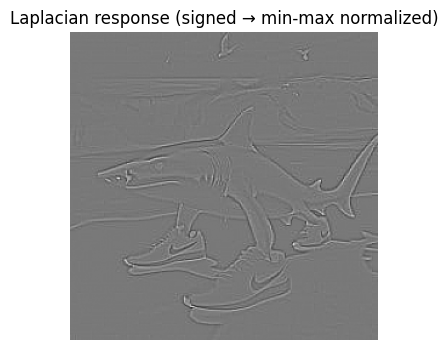

=== Sobel Vertical ===


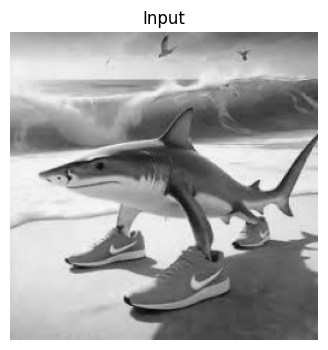

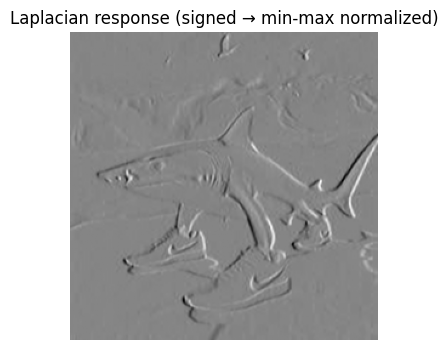

=== Sobel Horizontal ===


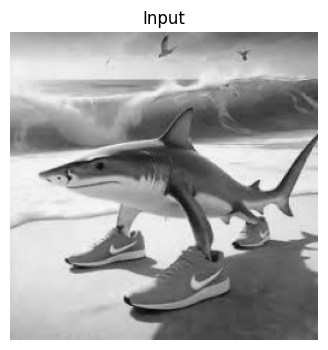

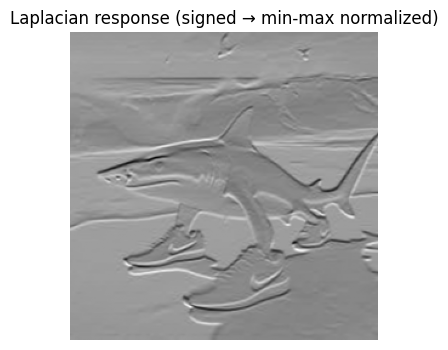

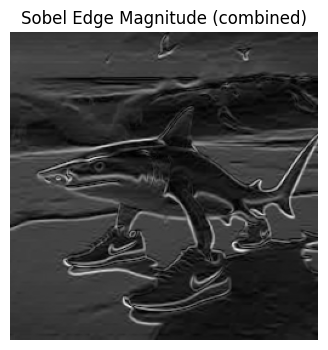

In [19]:
print('=== Laplacian ===')
resp_lp = apply_filter_and_visualize(img, laplace)

print('=== Sobel Vertical ===')
resp_sv = apply_filter_and_visualize(img, sobel_vertical)

print('=== Sobel Horizontal ===')
resp_sh = apply_filter_and_visualize(img, sobel_horizontal)

edge_mag = np.sqrt(resp_sv**2 + resp_sh**2)
edge_mag = minmax_norm(edge_mag)

show_gray(edge_mag, 'Sobel Edge Magnitude (combined)')

# Resnet18 구현하기

앞선 문제에서 Convolution 연산을 구현하여 보았으니,  
이번에는 **Resnet18을 직접 구현**해보고자 합니다.  
**Pytorch의 nn.Conv2d를 사용하시면 되지만**,  
본인이 구현한 Conv2d가 backward 연산이 가능하도록 설계되었다면 그것을 사용하여 구현하셔도 좋습니다.

**라이브러리 및 함수 정의**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

data_path = "./data"

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 31.4MB/s]


In [2]:
def train(model, trainloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=5e-4,
        momentum=0.9
    )
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(trainloader,desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

def test(model, testloader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

**Q1. CIFAR10 데이터셋을 분류하는 Resnet18 classifier를 구현하세요**

Input (Batch size x 3 x 32 x 32) / Output (Batch size x Num class)  
이미지 배치를 입력받아 label 개수에 맞는 logit을 반환하도록 BasicBlock과 ResNet18 class를 정의해주세요.  
**ImageNet(224x224)을 입력으로 받는 Original ResNet18과 달리 CIFAR10(32x32)을 입력으로 받으므로,**  
- **conv1과 conv2 layer의 filter size와, maxpooling, stride,**  
- **fc layer의 output dimension을 적절히 변형하셔야 합니다.**
- **ResNet의 Architecture는 아래와 같습니다**

![사진](./ResNet_Architectures.png)

In [7]:
import torch.nn as nn
import torch.nn.functional as F # Import F for functional API


class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_planes, planes, stride=1) -> None:
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):

    def __init__(self, num_classes=10) -> None:
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False) # Adjusted stride and kernel size for CIFAR10
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes) # Adjusted input features for fc layer

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # Removed MaxPooling as input size is small
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4) # Adjusted AvgPooling kernel size for CIFAR10
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

모델이 안정적으로 학습되는지, 테스트 정확도가 잘 나오는지 (80% 이상) 확인해보세요

In [8]:
torch.manual_seed(42)
model = ResNet18().to(device)
train(model, trainloader, epochs=20)

Epoch 1/20: 100%|██████████| 500/500 [00:43<00:00, 11.49it/s]


Epoch 1/20, Loss: 1.2665369663238526


Epoch 2/20: 100%|██████████| 500/500 [00:45<00:00, 10.99it/s]


Epoch 2/20, Loss: 0.7386989380717277


Epoch 3/20: 100%|██████████| 500/500 [00:44<00:00, 11.25it/s]


Epoch 3/20, Loss: 0.5252462159991265


Epoch 4/20: 100%|██████████| 500/500 [00:45<00:00, 11.11it/s]


Epoch 4/20, Loss: 0.3871259610950947


Epoch 5/20: 100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


Epoch 5/20, Loss: 0.28174574008584025


Epoch 6/20: 100%|██████████| 500/500 [00:44<00:00, 11.14it/s]


Epoch 6/20, Loss: 0.19696702564507723


Epoch 7/20: 100%|██████████| 500/500 [00:44<00:00, 11.12it/s]


Epoch 7/20, Loss: 0.13021629779040814


Epoch 8/20: 100%|██████████| 500/500 [00:44<00:00, 11.13it/s]


Epoch 8/20, Loss: 0.09825203987210988


Epoch 9/20: 100%|██████████| 500/500 [00:44<00:00, 11.12it/s]


Epoch 9/20, Loss: 0.0782696472723037


Epoch 10/20: 100%|██████████| 500/500 [00:44<00:00, 11.14it/s]


Epoch 10/20, Loss: 0.06649257699772716


Epoch 11/20: 100%|██████████| 500/500 [00:44<00:00, 11.13it/s]


Epoch 11/20, Loss: 0.04904585150070488


Epoch 12/20: 100%|██████████| 500/500 [00:44<00:00, 11.14it/s]


Epoch 12/20, Loss: 0.04051646264456212


Epoch 13/20: 100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


Epoch 13/20, Loss: 0.032697402565740045


Epoch 14/20: 100%|██████████| 500/500 [00:44<00:00, 11.16it/s]


Epoch 14/20, Loss: 0.025476958393584936


Epoch 15/20: 100%|██████████| 500/500 [00:44<00:00, 11.15it/s]


Epoch 15/20, Loss: 0.01899962407536805


Epoch 16/20: 100%|██████████| 500/500 [00:44<00:00, 11.12it/s]


Epoch 16/20, Loss: 0.011774806025903672


Epoch 17/20: 100%|██████████| 500/500 [00:44<00:00, 11.18it/s]


Epoch 17/20, Loss: 0.005620642975030932


Epoch 18/20: 100%|██████████| 500/500 [00:44<00:00, 11.21it/s]


Epoch 18/20, Loss: 0.001980569670617115


Epoch 19/20: 100%|██████████| 500/500 [00:44<00:00, 11.19it/s]


Epoch 19/20, Loss: 0.0008647442233050242


Epoch 20/20: 100%|██████████| 500/500 [00:44<00:00, 11.19it/s]

Epoch 20/20, Loss: 0.0007022509925009217


In [9]:
test(model, testloader, device)

Test Accuracy: 85.85%


85.85

**Q2. Original ResNet18과 CIFAR10 분류용으로 구현한 ResNet18의 차이점과 그렇게 수정한 이유를 아래 마크다운에 자세히 설명해주세요.**

CIFAR 10 이미지는 크기가 작기 때문에 커널 크기를 줄이고, stride를 1로 변경하여 정보 손실을 최소화하면서도 해상도를 유지할 수 있게 했다.

Max Pooling을 제거하여 공간 해상도 손실을 최소화하였다. 이미지 크기가 작기 때문에 해상도 손실이 치명적일 수도 있기 때문이다.

레이어 4를 거친 후의 feature map 크기가 4x4가 되기 때문에, 커널 크기를 조정하여 최종 출력 크기가 1x1로 출력되게끔 한다.